# ETF Risk–Return & Diversification — Auto Downloader
This notebook downloads daily Adj Close data for a set of ETFs, computes metrics, exports CSVs and saves charts (PNG). Edit the `tickers`, `start`, and `risk_free` below.

C:\Users\ishac\AppData\Local\Temp\ipykernel_1588\1834581479.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end, progress=False, group_by="ticker")


✅ Downloaded data successfully:
                   SPY         QQQ         XLV        XLE        VNQ  \
Date                                                                   
2022-01-03  453.210419  392.184082  131.198914  50.003014  99.251976   
2022-01-04  453.058563  387.097321  129.467682  51.733288  99.131256   
2022-01-05  444.358917  375.205292  128.545578  51.724556  96.294266   
2022-01-06  443.941467  374.941528  127.058937  52.878063  96.380478   
2022-01-07  442.186310  370.879852  126.409721  53.603371  95.742371   

                 ICLN  
Date                   
2022-01-03  20.298841  
2022-01-04  19.984941  
2022-01-05  19.052755  
2022-01-06  18.786417  
2022-01-07  18.700806  
Metrics:


,Annualized Return,Annualized Vol,Sharpe
SPY,11.57%,18.24%,63.43%
XLE,16.02%,26.22%,61.09%
QQQ,13.54%,23.92%,56.58%
XLV,2.47%,15.13%,16.35%
VNQ,-2.96%,20.12%,-14.71%
ICLN,-4.08%,27.38%,-14.92%


🔹 ML Model Performance: R² = 0.975, MAE = 0.0114


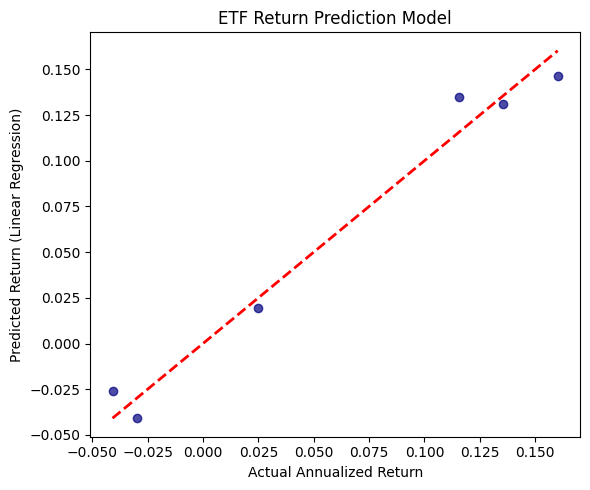


🔹 Model Coefficients:
          Feature  Coefficient
0  Annualized Vol     0.215877
1          Sharpe     0.229977
2       Intercept    -0.050547
Correlation matrix:


,SPY,QQQ,XLV,XLE,VNQ,ICLN
SPY,1.00,0.96,0.69,0.46,0.70,0.57
QQQ,0.96,1.00,0.55,0.33,0.58,0.55
XLV,0.69,0.55,1.00,0.32,0.65,0.40
XLE,0.46,0.33,0.32,1.00,0.35,0.30
VNQ,0.70,0.58,0.65,0.35,1.00,0.58
ICLN,0.57,0.55,0.40,0.30,0.58,1.00


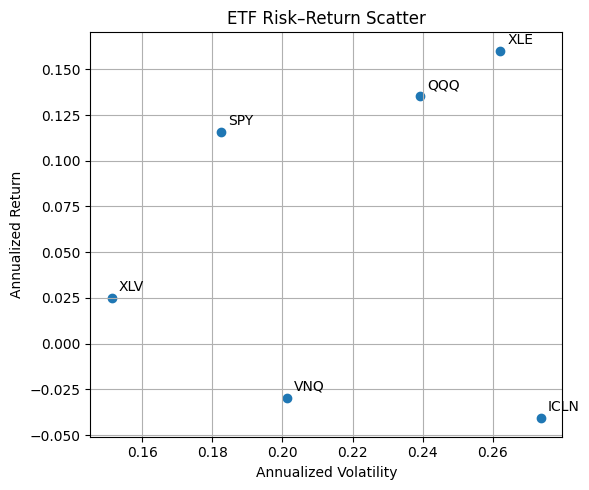

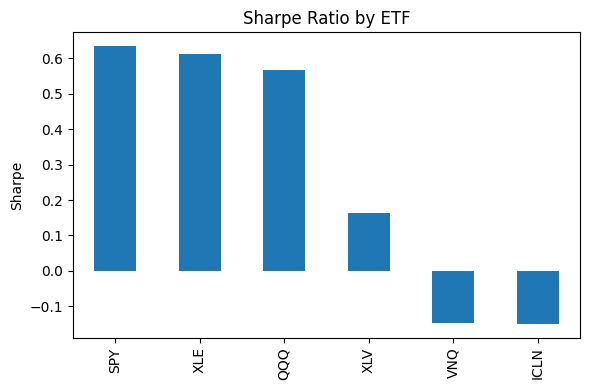

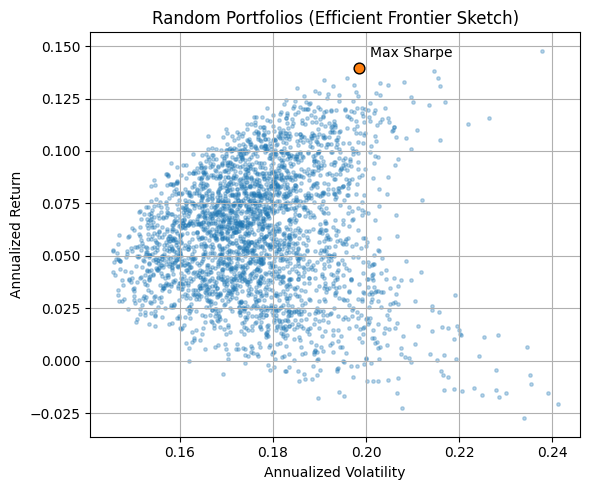

Saved files: metrics_etf.csv, correlations_etf.csv, prices_etf.csv, returns_etf.csv, risk_return_scatter.png, sharpe_by_etf.png, efficient_frontier.png


In [1]:

# --- Setup ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ---- Settings ----
tickers = ["SPY","QQQ","XLV","XLE","VNQ","ICLN"]
start = "2022-01-01"
end = None  # up to today
risk_free = 0.00  # annualized rf (set to 0.02 for 2% if desired)

# --- Download prices ---
raw = yf.download(tickers, start=start, end=end, progress=False, group_by="ticker")

# Handle both single- and multi-level column structures robustly
if isinstance(raw.columns, pd.MultiIndex):
    # If columns are hierarchical (Ticker -> Field)
    close_cols = []
    for t in tickers:
        try:
            close_cols.append(raw[(t, "Adj Close")])
        except KeyError:
            close_cols.append(raw[(t, "Close")])  # fallback if Adj Close missing
    data = pd.concat(close_cols, axis=1)
    data.columns = tickers
else:
    # Flat columns (single ticker or simplified download)
    if "Adj Close" in raw.columns:
        data = raw[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})
    elif "Close" in raw.columns:
        data = raw[["Close"]].rename(columns={"Close": tickers[0]})
    else:
        raise ValueError("No Adj Close or Close column found in Yahoo Finance data.")

# Clean up
data = data.dropna(how="all").ffill().dropna()
print("✅ Downloaded data successfully:")
print(data.head())


# --- Returns ---
rets = data.pct_change().dropna()

# --- Metrics ---
ann_factor = 252
ann_ret = (1 + rets).prod()**(ann_factor/len(rets)) - 1
ann_vol = rets.std() * np.sqrt(ann_factor)
sharpe = (ann_ret - risk_free) / ann_vol.replace(0, np.nan)

metrics = pd.DataFrame({
    "Annualized Return": ann_ret,
    "Annualized Vol": ann_vol,
    "Sharpe": sharpe
}).sort_values("Sharpe", ascending=False)

print("Metrics:")
display(metrics.style.format("{:.2%}"))

# --- MACHINE LEARNING MODULE: Predict ETF Returns ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Features and target
X = metrics[["Annualized Vol", "Sharpe"]]
y = metrics["Annualized Return"]

# Train model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print(f"🔹 ML Model Performance: R² = {r2:.3f}, MAE = {mae:.4f}")

# Visualize actual vs predicted returns
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred, color="navy", alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("Actual Annualized Return")
plt.ylabel("Predicted Return (Linear Regression)")
plt.title("ETF Return Prediction Model")
plt.tight_layout()
plt.savefig("etf_return_prediction.png", dpi=160)
plt.show()

# Save model summary
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_,
})
coef_df.loc[len(coef_df)] = ["Intercept", model.intercept_]
print("\n🔹 Model Coefficients:")
print(coef_df)


# --- Correlations ---
corr = rets.corr()
print("Correlation matrix:")
display(corr.style.format("{:.2f}"))

# --- Save CSVs ---
metrics.to_csv("metrics_etf.csv")
corr.to_csv("correlations_etf.csv")
data.to_csv("prices_etf.csv")
rets.to_csv("returns_etf.csv")

# --- Risk-Return scatter ---
plt.figure(figsize=(6,5))
plt.scatter(metrics["Annualized Vol"], metrics["Annualized Return"])
for t in metrics.index:
    x = metrics.loc[t, "Annualized Vol"]
    y = metrics.loc[t, "Annualized Return"]
    plt.annotate(t, (x, y), xytext=(5,5), textcoords="offset points")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("ETF Risk–Return Scatter")
plt.grid(True)
plt.tight_layout()
plt.savefig("risk_return_scatter.png", dpi=200)
plt.show()

# --- Sharpe bar chart ---
plt.figure(figsize=(6,4))
metrics["Sharpe"].plot(kind="bar")
plt.title("Sharpe Ratio by ETF")
plt.ylabel("Sharpe")
plt.tight_layout()
plt.savefig("sharpe_by_etf.png", dpi=200)
plt.show()

# --- Random portfolios (efficient frontier sketch) ---
n_port = 3000
weights = np.random.dirichlet(np.ones(len(tickers)), size=n_port)
port_rets = weights @ metrics["Annualized Return"].reindex(tickers).values
cov = rets.cov() * ann_factor
port_vols = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov.values, weights))
port_sharpe = (port_rets - risk_free) / port_vols

plt.figure(figsize=(6,5))
plt.scatter(port_vols, port_rets, s=6, alpha=0.3)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Random Portfolios (Efficient Frontier Sketch)")
i_star = np.nanargmax(port_sharpe)
plt.scatter(port_vols[i_star], port_rets[i_star], s=60, edgecolors="k")
plt.annotate("Max Sharpe", (port_vols[i_star], port_rets[i_star]), xytext=(8,8), textcoords="offset points")
plt.grid(True)
plt.tight_layout()
plt.savefig("efficient_frontier.png", dpi=200)
plt.show()

print("Saved files: metrics_etf.csv, correlations_etf.csv, prices_etf.csv, returns_etf.csv, "
      "risk_return_scatter.png, sharpe_by_etf.png, efficient_frontier.png")
